In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [20]:
data = pd.read_csv('Wave_Current_ Speeds_TimeSeries(1.5m).csv', index_col=['DateTime'], parse_dates=['DateTime'])


In [53]:
X = data[['Wave Speed']].values  # Input: Wave Speed
y = data['Current speed'].values  # Output: Current Speed


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [55]:
# Convert the NumPy arrays to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()


In [56]:
X_train = X_train.requires_grad_()


In [57]:
class CurrentSpeedPINN(torch.nn.Module):
    def __init__(self):
        super(CurrentSpeedPINN, self).__init__()
        self.dense1 = torch.nn.Linear(1, 32)  # First hidden layer with 32 neurons
        self.dense2 = torch.nn.Linear(32, 32)  # Second hidden layer with 32 neurons
        self.output_layer = torch.nn.Linear(32, 1)  # Output layer with one neuron for predicting Current Speed

    def forward(self, inputs):
        x = self.dense1(inputs)  # Pass input through the first hidden layer
        x = self.dense2(x)  # Pass through the second hidden layer
        output = self.output_layer(x)  # Output prediction
        return output

In [65]:
def physics_loss(model, X):
    predictions = model(X)
    u_pred = predictions[:, 0]
    v_pred = predictions[:, 0]  # Both u_pred and v_pred have the same value.

    # Define the physics-based equations
    g = 9.81
    f = 1.0e-4
    h = 1.5
    u = u_pred  # Define u based on predictions
    v = v_pred  # Define v based on predictions


# Compute the spatial derivatives of u and v
    u_x = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    v_x = torch.autograd.grad(v, X, grad_outputs=torch.ones_like(v), create_graph=True, retain_graph=True)[0]
    v_y = torch.autograd.grad(v, X, grad_outputs=torch.ones_like(v), create_graph=True, retain_graph=True)[0]


    h_x = 1.5  # Define h_x based on data or calculations
    h_y = 1.5  # Define h_y based on data or calculations

    physics_equations = [
        -u * u_x - v * u_y - f * u + g * h_x,
        -u * v_x - v * v_y + f * v + g * h_y
    ]


    # Compute the data loss
    data_loss = torch.mean(torch.square(predictions.detach() - y))


# Compute the physics loss
    physics_equations = torch.stack(physics_equations)
    physics_loss_value = torch.mean(torch.square(physics_equations))



    # Compute the total loss
    total_loss = data_loss + physics_loss_value

    return physics_loss_value, data_loss, total_loss


In [66]:
# Define training hyperparameters
learning_rate = 0.001  # Learning rate for optimization
epochs = 10000  # Number of training epochs

model = CurrentSpeedPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [73]:
 # Training Loop
#for epoch in range(epochs):
    #optimizer.zero_grad()
    #physics_loss_value, data_loss, total_loss = physics_loss(model, X_train)
    #total_loss.backward()
    #optimizer.step()

    #if epoch % 100 == 0:
        #print(f"Epoch [{epoch}/{epochs}] - Physics Loss: {physics_loss_value.item()}, Data Loss: {data_loss.item()}, Total Loss: {total_loss.item()}")

# Training Loop
losses = {'physics_loss': [], 'data_loss': [], 'total_loss': []}

for epoch in range(epochs):
    optimizer.zero_grad()
    physics_loss_value, data_loss, total_loss = physics_loss(model, X_train)
    total_loss.backward()
    optimizer.step()
    
    # Append losses to the dictionary for analysis
    losses['physics_loss'].append(physics_loss_value.item())
    losses['data_loss'].append(data_loss.item())
    losses['total_loss'].append(total_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}] - Physics Loss: {physics_loss_value.item()}, Data Loss: {data_loss.item()}, Total Loss: {total_loss.item()}")


Epoch [0/10000] - Physics Loss: 0.007029883563518524, Data Loss: 277.3337009770347, Total Loss: 277.3407308605982
Epoch [100/10000] - Physics Loss: 0.008663643151521683, Data Loss: 252.11888339520965, Total Loss: 252.12754703836117
Epoch [200/10000] - Physics Loss: 0.007961253635585308, Data Loss: 260.6939435361713, Total Loss: 260.70190478980686
Epoch [300/10000] - Physics Loss: 0.007456052582710981, Data Loss: 269.33298068746, Total Loss: 269.3404367400427
Epoch [400/10000] - Physics Loss: 0.007000843062996864, Data Loss: 277.9385291037839, Total Loss: 277.9455299468469
Epoch [500/10000] - Physics Loss: 0.008144221268594265, Data Loss: 258.5832797612894, Total Loss: 258.591423982558
Epoch [600/10000] - Physics Loss: 0.0075645786710083485, Data Loss: 267.4038360950544, Total Loss: 267.4114006737254
Epoch [700/10000] - Physics Loss: 0.0070878444239497185, Data Loss: 276.20390752684847, Total Loss: 276.2109953712724
Epoch [800/10000] - Physics Loss: 0.008354650810360909, Data Loss: 258.

Epoch [7000/10000] - Physics Loss: 0.007129339035600424, Data Loss: 275.4023351318712, Total Loss: 275.4094644709068
Epoch [7100/10000] - Physics Loss: 0.006575717590749264, Data Loss: 286.7018371782008, Total Loss: 286.7084128957915
Epoch [7200/10000] - Physics Loss: 0.013848851434886456, Data Loss: 261.1898939948061, Total Loss: 261.20374284624097
Epoch [7300/10000] - Physics Loss: 0.00749777490273118, Data Loss: 268.5866515302413, Total Loss: 268.594149305144
Epoch [7400/10000] - Physics Loss: 0.006888396106660366, Data Loss: 280.1524226856755, Total Loss: 280.15931108178216
Epoch [7500/10000] - Physics Loss: 0.006361791398376226, Data Loss: 291.4660050290614, Total Loss: 291.4723668204598
Epoch [7600/10000] - Physics Loss: 0.007817821577191353, Data Loss: 264.1312112470599, Total Loss: 264.1390290686371
Epoch [7700/10000] - Physics Loss: 0.007103063631802797, Data Loss: 275.90898401856896, Total Loss: 275.91608708220076
Epoch [7800/10000] - Physics Loss: 0.00653880788013339, Data L

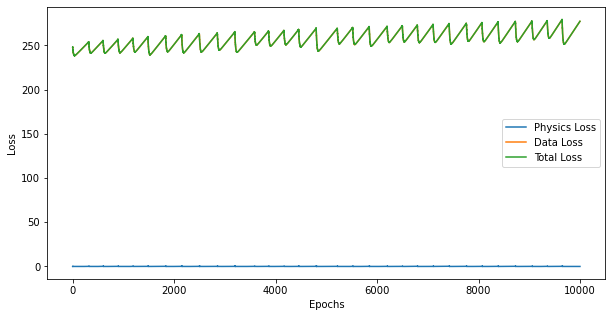

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), losses['physics_loss'], label='Physics Loss')
plt.plot(range(epochs), losses['data_loss'], label='Data Loss')
plt.plot(range(epochs), losses['total_loss'], label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [71]:
# After training, evaluate the model on the test data
with torch.no_grad():
    y_pred = model(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 277.48797607421875
Mean Absolute Error: 16.65764045715332


In [72]:
# After training, evaluate the model on the test data
with torch.no_grad():
    y_pred = model(X_test)
    mse = torch.mean(torch.square(y_test - y_pred)).item()
    mae = torch.mean(torch.abs(y_test - y_pred)).item()

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")

    # You can also print and compare some actual and predicted values
    print("Actual Values:", y_test[:10])  # Print the first 10 actual values
    print("Predicted Values:", y_pred[:10])  # Print the first 10 predicted values


Mean Squared Error: 277.488037109375
Mean Absolute Error: 16.65764045715332
Actual Values: tensor([0.0990, 0.0608, 0.1020, 0.1438, 0.0558, 0.1136, 0.1474, 0.0658, 0.0518,
        0.1552])
Predicted Values: tensor([[-16.5430],
        [-16.7479],
        [-16.4069],
        [-16.4678],
        [-16.4863],
        [-16.5148],
        [-16.6914],
        [-16.7618],
        [-16.4990],
        [-16.5652]])


In [74]:
def physics_loss(model, X):
    predictions = model(X)
    u_pred = predictions[:, 0]
    v_pred = predictions[:, 0]  # Both u_pred and v_pred have the same value.

    # Define the physics-based equations
    g = 9.81
    f = 1.0e-4
    h = 1.5
    u = u_pred  # Define u based on predictions
    v = v_pred  # Define v based on predictions


# Compute the spatial derivatives of u and v
    u_x = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    v_x = torch.autograd.grad(v, X, grad_outputs=torch.ones_like(v), create_graph=True, retain_graph=True)[0]
    v_y = torch.autograd.grad(v, X, grad_outputs=torch.ones_like(v), create_graph=True, retain_graph=True)[0]


    h_x = 1.5  # Define h_x based on data or calculations
    h_y = 1.5  # Define h_y based on data or calculations

    physics_equations = [
        -u * u_x - v * u_y - f * u + g * h_x,
        -u * v_x - v * v_y + f * v + g * h_y
    ]


    # Compute the data loss
    data_loss = torch.mean(torch.abs(predictions.detach() - y))


# Compute the physics loss
    physics_equations = torch.stack(physics_equations)
    physics_loss_value = torch.mean(torch.abs(physics_equations))



    # Compute the total loss
    total_loss = data_loss + physics_loss_value
    
    total_loss = torch.mean(torch.abs(total_loss))
    
    return physics_loss_value, data_loss, total_loss


In [76]:
# Define training hyperparameters
learning_rate = 0.009  # Learning rate for optimization
epochs = 10000  # Number of training epochs

model = CurrentSpeedPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [77]:
# Training Loop
losses = {'physics_loss': [], 'data_loss': [], 'total_loss': []}

for epoch in range(epochs):
    optimizer.zero_grad()
    physics_loss_value, data_loss, total_loss = physics_loss(model, X_train)
    total_loss.backward()
    optimizer.step()
    
    # Append losses to the dictionary for analysis
    losses['physics_loss'].append(physics_loss_value.item())
    losses['data_loss'].append(data_loss.item())
    losses['total_loss'].append(total_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}] - Physics Loss: {physics_loss_value.item()}, Data Loss: {data_loss.item()}, Total Loss: {total_loss.item()}")


Epoch [0/10000] - Physics Loss: 14.642559051513672, Data Loss: 0.06380316496750926, Total Loss: 14.706362216481182
Epoch [100/10000] - Physics Loss: 0.3779228627681732, Data Loss: 7.234047454976781, Total Loss: 7.611970317744954
Epoch [200/10000] - Physics Loss: 0.5430377721786499, Data Loss: 6.022113867229837, Total Loss: 6.565151639408487
Epoch [300/10000] - Physics Loss: 0.31663602590560913, Data Loss: 7.815377704583986, Total Loss: 8.132013730489595
Epoch [400/10000] - Physics Loss: 0.37728580832481384, Data Loss: 7.112484076271756, Total Loss: 7.48976988459657
Epoch [500/10000] - Physics Loss: 0.32972460985183716, Data Loss: 7.738021476726075, Total Loss: 8.067746086577912
Epoch [600/10000] - Physics Loss: 0.3971325755119324, Data Loss: 8.600528662667791, Total Loss: 8.997661238179724
Epoch [700/10000] - Physics Loss: 0.3250409960746765, Data Loss: 8.14513567123849, Total Loss: 8.470176667313167
Epoch [800/10000] - Physics Loss: 0.28484150767326355, Data Loss: 9.025318757917061, T

Epoch [7100/10000] - Physics Loss: 0.19800083339214325, Data Loss: 11.890338867451277, Total Loss: 12.08833970084342
Epoch [7200/10000] - Physics Loss: 0.12532684206962585, Data Loss: 12.689353214302578, Total Loss: 12.814680056372204
Epoch [7300/10000] - Physics Loss: 0.13380037248134613, Data Loss: 12.059094097078104, Total Loss: 12.19289446955945
Epoch [7400/10000] - Physics Loss: 0.1341976672410965, Data Loss: 12.349283118068808, Total Loss: 12.483480785309904
Epoch [7500/10000] - Physics Loss: 0.12953104078769684, Data Loss: 12.158449462015046, Total Loss: 12.287980502802743
Epoch [7600/10000] - Physics Loss: 0.2950224280357361, Data Loss: 12.908396504185463, Total Loss: 13.203418932221199
Epoch [7700/10000] - Physics Loss: 0.27060171961784363, Data Loss: 12.875799086801974, Total Loss: 13.146400806419818
Epoch [7800/10000] - Physics Loss: 0.17138752341270447, Data Loss: 12.552959061196121, Total Loss: 12.724346584608826
Epoch [7900/10000] - Physics Loss: 0.20382744073867798, Data

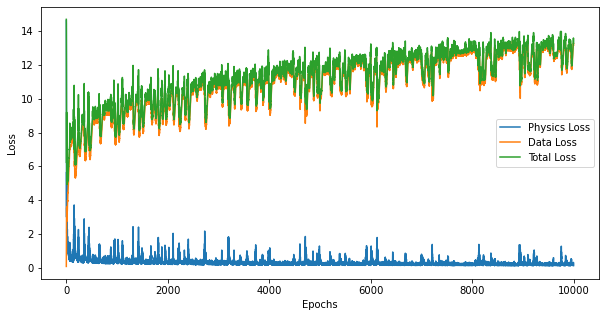

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), losses['physics_loss'], label='Physics Loss')
plt.plot(range(epochs), losses['data_loss'], label='Data Loss')
plt.plot(range(epochs), losses['total_loss'], label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [80]:

with torch.no_grad():
    y_pred = model(X_test)

    # Convert tensors to NumPy arrays for plotting
    y_test_numpy = y_test.cpu().numpy()
    y_pred_numpy = y_pred.cpu().numpy()

    mse = torch.mean(torch.square(y_test - y_pred)).item()
    mae = torch.mean(torch.abs(y_test - y_pred)).item()

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")

  


Mean Squared Error: 172.99720764160156
Mean Absolute Error: 13.152223587036133


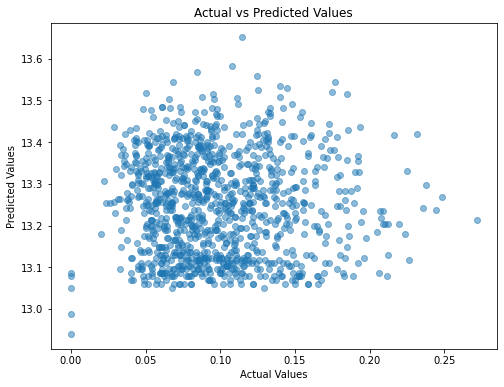

In [82]:
  # Plot actual versus predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_numpy, y_pred_numpy, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

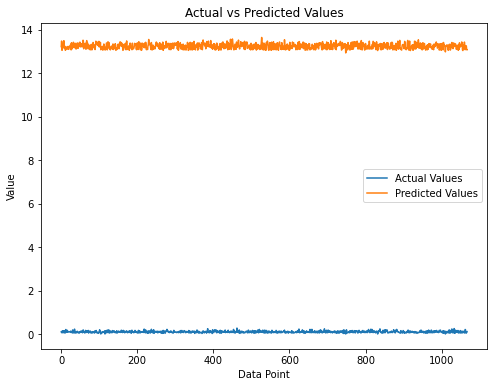

In [84]:
# Plot actual versus predicted values as a line plot
plt.figure(figsize=(8, 6))
plt.plot(y_test_numpy, label='Actual Values')
plt.plot(y_pred_numpy, label='Predicted Values')
plt.xlabel("Data Point")
plt.ylabel("Value")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()